# Imports

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Sampling Functions

## Defining Constants

In [93]:
## Parameters for Two Well 1-D Potential

epsilon_0 = 2
epsilon_1 = 1
epsilon_2 = 1
sigma = 0.3

## Parameters for Hookian Restraint Potential
k = 100

## Defining Landscape Potential Functions

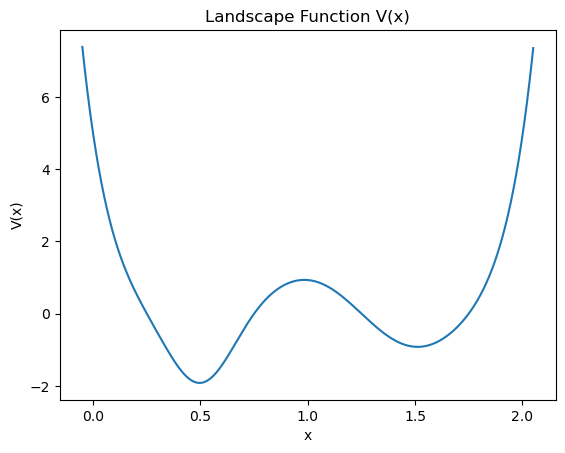

In [94]:
def two_well_1d(x, epsilon_0, epsilon_1, epsilon_2, sigma):
    """
    Defines the landscape function V(x) as described in the image.

    Args:
    x (float or numpy.ndarray): The independent variable.
    epsilon_0 (float): Parameter epsilon_0.
    epsilon_1 (float): Parameter epsilon_1.
    epsilon_2 (float): Parameter epsilon_2.
    sigma (float): Parameter sigma.

    Returns:
    float or numpy.ndarray: The value of the function V(x).
    """

    term1 = 5 * (x - 1)**8
    term2 = epsilon_0 * np.exp((-epsilon_0 * (x - 0.5)**2) / sigma**2)
    term3 = epsilon_1 * np.exp((-epsilon_1 * (x - 1.0)**2) / sigma**2)
    term4 = epsilon_2 * np.exp((-epsilon_2 * (x - 1.5)**2) / sigma**2)

    return term1 - term2 + term3 - term4

def plot_landscape_fxn(V: callable):
    """
    Plots the landscape function V(x) as described in the image.
    """

    x = np.linspace(-0.05, 2.05, 1000)
    y = V(x, epsilon_0, epsilon_1, epsilon_2, sigma)

    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.title('Landscape Function V(x)')
    plt.show()

plot_landscape_fxn(two_well_1d)

## Defining Restoring Bias Functions

In [95]:
Nwindows = 100
min_x = -0.05
max_x = 2.05
dx = (max_x - min_x) / Nwindows

# range of x values
x = np.linspace(min_x, max_x, Nwindows)

# define bias functions for each window
bias: list[callable] = []

centers = np.linspace(min_x + dx/2, max_x - dx/2, Nwindows)
for center in centers:
    # Correct way to capture the value of 'center'
    psi = lambda x, c=center: 0.5 * k * (x - c)**2  # harmonic potential
    bias.append(psi)

### Plot Restoring Bias Functions

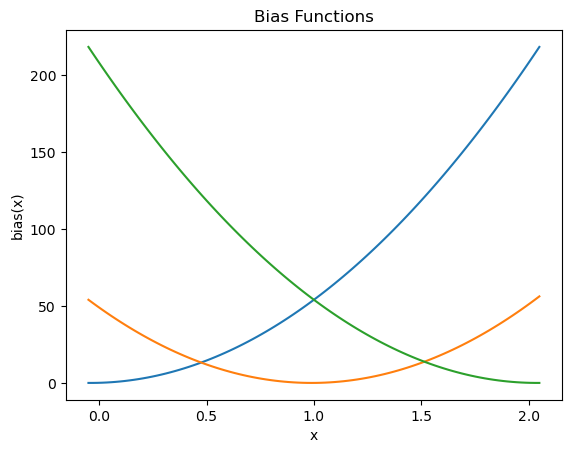

In [96]:
# plot the bias functions

# get the 1, 50, 99 bias functions
for psi in [bias[0], bias[49], bias[99]]:
    plt.plot(x, psi(x))
    
plt.xlabel('x')
plt.ylabel('bias(x)')
plt.title('Bias Functions')
plt.show()

# Monte-Carlo Sampling

Now, we actually implement the Monte-Carlo sampling algorithm to sample from the landscape potential function in the presence of a restoring bias function (which is essentially sampling from a window of the landscape potential function).

## Constants

In [97]:
T = 298 # K
kB = 1.38064852e-2 # Boltzmann constant (zJ/K)
beta = 1 / (kB * T)
printModulus = 10 # frequency of prints to screen
writeModulus = 10  # frequency of writes to file
dispSize = 0.05
nSweeps = 5000 # number of MC sweeps

## Helper Functions

## Monte-Carlo Sampling Algorithm

In [ ]:
samples = np.zeros((Nwindows, nSweeps))

def monte_carlo_sampling_per_window(args):
    """
    Perform Monte Carlo sampling of the biased distribution for a given window.

    Args:
    window_index (int): The index of the window.
    biases (callable): The list of bias functions for each window.
    V (callable): The landscape function V(x).

    Returns:
    numpy.ndarray: The samples drawn from the biased distribution.
    """

    # unpack the arguments
    window_index, biases, V = args

    # get the bias function for the window
    bias = biases[window_index]
    
    # define the range of x values for the window
    start_x = min_x + window_index * dx
    end_x = start_x + dx

    # pick a random starting point in the window and get potential energy
    current_x = np.random.uniform(start_x, end_x)
    current_U = V(current_x, epsilon_0, epsilon_1, epsilon_2, sigma) + bias(current_x)

    for sweep in range(nSweeps):
        # propose a new position
        proposed_x = current_x + dispSize * np.random.uniform(-1, 1)
        proposed_U = V(proposed_x, epsilon_0, epsilon_1, epsilon_2, sigma) + bias(proposed_x)

        # acceptance criterion
        delta_U = proposed_U - current_U
        acceptance_prob = min(0, -beta * delta_U)

        # accept or reject
        if np.log(np.random.uniform()) < acceptance_prob:
            current_x = proposed_x
            current_U = proposed_U

        samples[window_index, sweep] = current_x
        
        # print to screen and write to file
        # if sweep % printModulus == 0:
        #     print(f'Window {window_index}, Sweep {sweep}, x = {current_x:.3f}, U = {current_U:.3f}')
        #     print(f"Acceptance probability: {acceptance_prob}")

def parallel_monte_carlo_sampling(biases, V):
    """
    Perform Monte Carlo sampling of the biased distribution in parallel.

    Args:
    biases (list[callable]): The list of bias functions for each window.
    V (callable): The landscape function V(x).

    Returns:
    numpy.ndarray: The samples drawn from the biased distribution.
    """
    pool = Pool()
    # create a list of arguments for the monte_carlo_sampling_per_window function
    args = [(i, biases, V) for i in range(Nwindows)]

    # perform the sampling in parallel
    for arg in args:
        monte_carlo_sampling_per_window(arg)

In [99]:
monte_carlo_sampling_per_window(0, bias, two_well_1d)

print(samples[0, :10])

-0.19502732856264973
Window 0, Sweep 0, x = -0.054, U = 7.623
Acceptance probability: -0.19502732856264973
0
0
0
0
-0.20854812562212788
0
-0.11495371363864672
-0.09950041756243619
-0.42766800004483874
-0.33907421319519987
Window 0, Sweep 10, x = -0.050, U = 7.374
Acceptance probability: -0.33907421319519987
-0.1626539975372345
-0.1648102145401813
0
0
-0.22493147183034204
0
0
-0.05597566742642821
0
-0.0519791307148777
Window 0, Sweep 20, x = -0.004, U = 5.202
Acceptance probability: -0.0519791307148777
-0.16332716259546792
-0.20323018730499434
0
0
0
0
0
-0.036932898531009596
-0.11274175949529606
0
Window 0, Sweep 30, x = 0.179, U = 3.216
Acceptance probability: 0
0
-0.047774779956951244
-0.08182368724169288
-0.10875029713936381
-0.025849662793278175
0
0
0
0
-0.025253183814494755
Window 0, Sweep 40, x = 0.163, U = 3.093
Acceptance probability: -0.025253183814494755
-0.11762170909679598
0
-0.16826776963274478
0
-0.06250911436265882
-0.011783514642684114
0
-0.057455029623890125
0
0
Window 

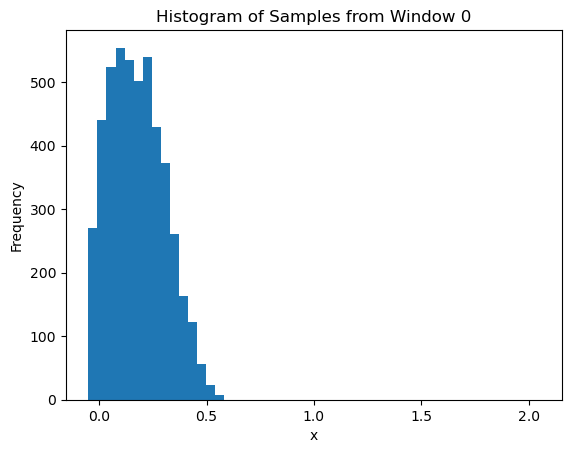

In [102]:
# plot histogram of samples from window 0
plt.hist(samples[0, :], bins=50, range=(min_x, max_x))
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Histogram of Samples from Window 0')
plt.show()